# ***Semantic Segmentation using PSP-Net with VGG-16 as Background with Keras and TensorFlow***

# **Installing Librarires**

In [ ]:
!pip install segmentation-models
!pip install keras==2.9.0
!pip install livelossplot
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0+zzzcolab20220506150900 requires keras<2.8,>=2.7.0rc0, but you have keras 2.9.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [ ]:
%matplotlib inline

# **Importing Libraries**

In [ ]:
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
from skimage import io, util
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import data, io
from matplotlib import pyplot as plt
from keras import backend as K
import os
import random
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Concatenate
from keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu


## **Unzip Data**

In [ ]:
!unzip '/content/A3_Dataset.zip' 

Archive:  /content/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.png  
 

# **Loading the Dataset**

## **Load and Preprocess Train Images**

In [ ]:
Xsize = 384
Ysize = 384

images_train = []
masks_training = [] 
for dir_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_train"):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Ysize, Xsize))
        images_train.append(image)
       

for dir_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_train"):
    for mask_path in glob.glob(os.path.join(dir_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Ysize, Xsize)) 
        masks_training.append(mask)

images_train = np.array(images_train)      
masks_training = np.array(masks_training)



## **Load and Preprocess Test Images**

In [ ]:

Xsize = 384 
Ysize = 384

images_test = []
masks_test = [] 
for dir_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_test"):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Ysize, Xsize))
        images_test.append(image)


for dir_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_test"):
    for mask_path in glob.glob(os.path.join(dir_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Ysize, Xsize))
        masks_test.append(mask)

images_test = np.array(images_test)  
masks_test = np.array(masks_test)



## **Obtain Train and Test Data**

In [ ]:
input_train_mask = np.expand_dims(masks_training, axis=3)
X_train = images_train
y_train = input_train_mask
masks_test_input = np.expand_dims(masks_test, axis=3)
X_test = images_test
y_test = masks_test_input

In [ ]:
X_test.shape

(101, 384, 384, 3)

## **OHE**

In [ ]:
n_classes=12 #Number of classes for segmentation
from tensorflow.keras.utils import to_categorical
masks_training_category = to_categorical(y_train, num_classes=n_classes)
training_cat_y = masks_training_category.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
masks_test_category = to_categorical(y_test, num_classes=n_classes)
testing_cat_y = masks_test_category.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [ ]:
testing_cat_y.shape

(101, 384, 384, 12)

## **Display Data**

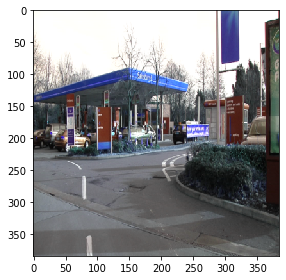

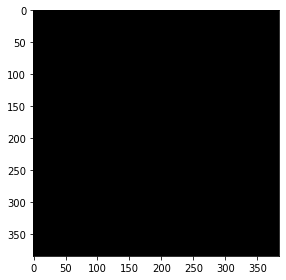

In [ ]:
def show(img):
  io.imshow(img)
  plt.show()

show(X_train[5])
show(np.argmax(y_train[5],axis=2))

# **PSP-Net with VGG16 as Background**

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
#setting the framework
sm.set_framework('tf.keras')

## **Model Compialtion**

In [ ]:

BACKBONE1 = 'vgg16'
Batch_size=10
LR=0.001
epochs=25
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train = preprocess_input1(X_train)
X_test = preprocess_input1(X_test)
activation='softmax'
# define model(Transfer Learning)
model1 = sm.PSPNet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model1.compile(optim, total_loss, metrics)
# compile keras model with defined optimozer, loss and metrics
#model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",metrics])

#Check the model summary
print(model1.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 384, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 384, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 6.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


## **Model Training and Saving**

In [ ]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    ]
history1=model1.fit(X_train, 
          training_cat_y,
          batch_size=Batch_size, 
          epochs=epochs,
          verbose=1,callbacks = callbacks,
          validation_data=(X_test, testing_cat_y))

model1.save('vgg16_backbone_pspnet.h5')

Epoch 1/25
37/37 [==============================] - 53s 788ms/step - loss: 0.7000 - iou_score: 0.2557 - f1-score: 0.3242 - val_loss: 0.8397 - val_iou_score: 0.2152 - val_f1-score: 0.2636 - lr: 0.0010
Epoch 2/25
37/37 [==============================] - 20s 544ms/step - loss: 0.5935 - iou_score: 0.3480 - f1-score: 0.4383 - val_loss: 0.6840 - val_iou_score: 0.3077 - val_f1-score: 0.3798 - lr: 0.0010
Epoch 3/25
37/37 [==============================] - 20s 541ms/step - loss: 0.5470 - iou_score: 0.3873 - f1-score: 0.4878 - val_loss: 0.6114 - val_iou_score: 0.3563 - val_f1-score: 0.4246 - lr: 0.0010
Epoch 4/25
37/37 [==============================] - 20s 552ms/step - loss: 0.5194 - iou_score: 0.4090 - f1-score: 0.5129 - val_loss: 0.4562 - val_iou_score: 0.4623 - val_f1-score: 0.5746 - lr: 0.0010
Epoch 5/25
37/37 [==============================] - 21s 569ms/step - loss: 0.4953 - iou_score: 0.4285 - f1-score: 0.5369 - val_loss: 0.4353 - val_iou_score: 0.4822 - val_f1-score: 0.5998 - lr: 0.0010


# **Quantitative Performance Measures**

## **Loss Curve**

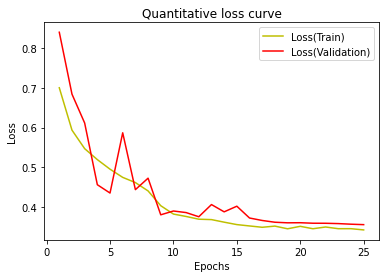

In [ ]:
#plotting the cross entropy loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Loss(Train)')
plt.plot(epochs, val_loss, 'r', label='Loss(Validation)')
plt.title('Quantitative loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **IOU Curve**

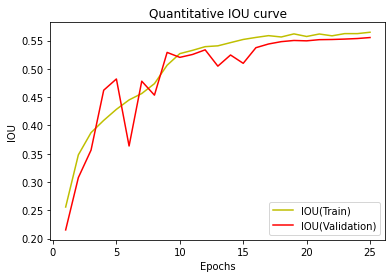

In [ ]:
#plotting the iou score
iou_score = history1.history['iou_score']
val_iou_score = history1.history['val_iou_score']
plt.plot(epochs, iou_score, 'y', label='IOU(Train)')
plt.plot(epochs, val_iou_score, 'r', label='IOU(Validation)')
plt.title('Quantitative IOU curve')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


## **F1 Score**

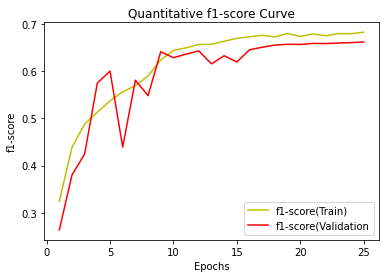

In [ ]:
#plotting the f1 score
f1_score = history1.history['f1-score']
val_f1_score = history1.history['val_f1-score']
plt.plot(epochs, f1_score, 'y', label='f1-score(Train)')
plt.plot(epochs, val_f1_score, 'r', label='f1-score(Validation')
plt.title('Quantitative f1-score Curve')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

# **Loading the Trained Model and Making Predictions**

In [ ]:
from keras.models import load_model
model1_load = load_model('/content/vgg16_backbone_pspnet.h5', compile=False)

In [ ]:
y_pred1=model1_load.predict(X_test)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

In [ ]:
print(y_pred1.shape)
print(y_pred1_argmax.shape)

(101, 384, 384, 12)
(101, 384, 384)
